
Colin Smith

# One-versus-Many: Predicting passenger survival on the *Titanic* using decision trees

**Note:** The dataset is from the [Vanderbilt Biostatistics Datasets](https://hbiostat.org/data/).

## Overview

Having worked with the *Titanic* dataset using logistic regression and naive Bayes to predict the survivability of passengers on the *Titanic*, it is time to try out decision trees on this dataset.

Using scikit-learn and the [`titanic.csv`](https://www.ecst.csuchico.edu/~bjuliano/csci581/datasets/titanic.csv) dataset, you will

1.   Develop a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classifier.
2.   Develop a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier. For this classifier, be sure to find an optimal forest size (*i.e.* value for the `n_estimators` parameter).
3.   Compare the performance of the two classifiers when predicting whether a passenger will survive or not. Explain which of the two classifiers demonstrates the better performance and why you believe that is the case.



## Data

You will be using the same [`titanic.csv`](https://www.ecst.csuchico.edu/~bjuliano/csci581/datasets/titanic.csv) dataset we used in Assignments #3 and #4.

The file [`titanic.csv`](https://www.ecst.csuchico.edu/~bjuliano/csci581/datasets/titanic.csv) contains the details of the 1309 passengers on board and importantly, will reveal whether they survived or not.
The dataset file details include:

*   `pclass`: passenger class; proxy for socio-economic status (1st ~ upper, 2nd ~ middle, 3rd ~ lower)
*   `survived`: survival status (0=No, 1=Yes)
*   `name`: passenger name
*   `sex`: passenger sex (male, female)
*   `age`: passenger age in years (fractional if age is less than 1; if age is estimated, it is in the form xx.5)
*   `sibsp`: number of siblings/spouses aboard (includes step-siblings; mistresses and fiances ignored)
*   `parch`: number of parents/children aboard (parent only considers mother or father; child includes stepchildren)
*   `ticket`: ticket number
*   `fare`: passenger fare (in pre-1970 British pounds)
*   `cabin`: cabin number
*   `embarked`: port of embarkation (C=Cherbourg, Q=Queenstown, S=Southampton)
*   `boat`: lifeboat number (if passenger boarded one)
*   `body`: body identification number
*   `home.dest`: passenger home/destination


#Solution

##Load the dependancies

In [ ]:
%%capture
!pip install itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import io
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.metrics import confusion_matrix

##Analyze the data

In [ ]:
df = pd.read_csv('https://www.ecst.csuchico.edu/~bjuliano/csci581/datasets/titanic.csv')
columns = df.columns
print(columns)

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


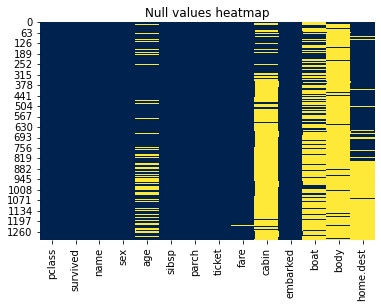

In [ ]:
ax = plt.axes()
sns.heatmap(df.isnull(), cmap = 'cividis', cbar=False, ax=ax)
ax.set_title('Null values heatmap')
plt.show()

Here we can see that their is a lot of nulls values in the home destination, body id, boat, and cabin number.
Using features like name, home destination and body id for our analysis wouldnt make sense so we will drop those three. Cabin Id unfortunately had too many null values and isnt numeric so it too will be removed. I also believe boat would be a bad feature, as its value is dependent if you made it off the ship, so I will remove it as well. The last one I will remove here is ticket, since from what I can tell doesn't mean anything once on the ship, and if it did we have pclass and fare for that. So we can remove it.

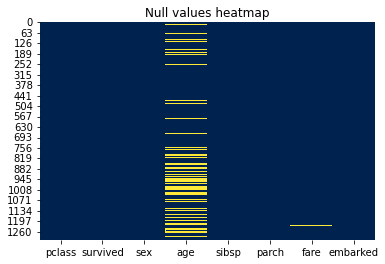

In [ ]:
df = df.drop(columns=['ticket','name','cabin', 'body', 'boat', 'home.dest'])
ax = plt.axes()
sns.heatmap(df.isnull(), cmap = 'cividis', cbar=False, ax=ax)
ax.set_title('Null values heatmap')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.9+ KB


Now we can see that our graph isn't fully accurate, as embarked has a null value but it doesnt show up. We will have to fill the NA values for all 3

Before we can accurately describe the data we have to change any stings to numbers

In [ ]:
df['sex'].replace(['male', 'female'], [0, 1], inplace=True)
df['embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace=True)

In [ ]:
df.describe()

pclass     survived          sex          age        sibsp  \
count  1309.000000  1309.000000  1309.000000  1046.000000  1309.000000   
mean      2.294882     0.381971     0.355997    29.881138     0.498854   
std       0.837836     0.486055     0.478997    14.413493     1.041658   
min       1.000000     0.000000     0.000000     0.170000     0.000000   
25%       2.000000     0.000000     0.000000    21.000000     0.000000   
50%       3.000000     0.000000     0.000000    28.000000     0.000000   
75%       3.000000     1.000000     1.000000    39.000000     1.000000   
max       3.000000     1.000000     1.000000    80.000000     8.000000   

             parch         fare     embarked  
count  1309.000000  1308.000000  1307.000000  
mean      0.385027    33.295479     1.492731  
std       0.865560    51.758668     0.814626  
min       0.000000     0.000000     0.000000  
25%       0.000000     7.895800     1.000000  
50%       0.000000    14.454200     2.000000  
75%       0.000000    31.275000     2.000000  
max       9.000000   512.329200     2.000000

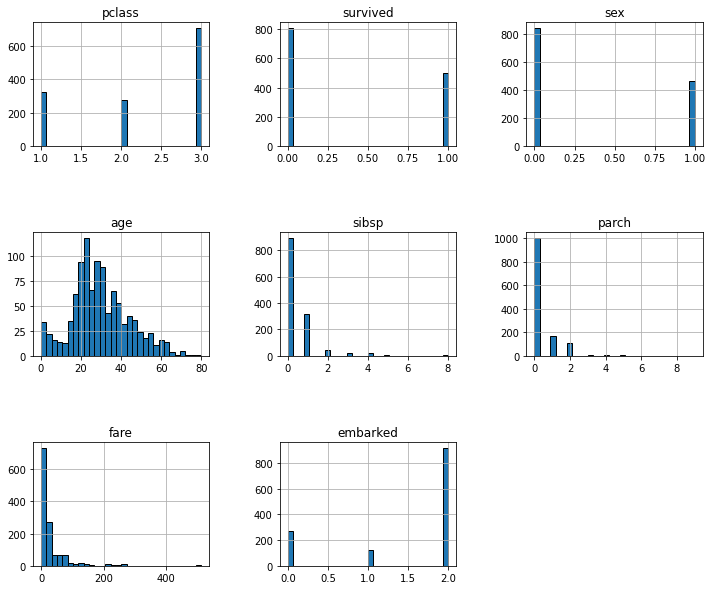

In [ ]:
df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

From this we can see that the average age was 29.88 we will round to 30 and use it to fill our missing nulls, and we only have one missing value for fare we will also just replace it with the mean rounded to 33, we can also see that embarked is mostly 2 so we will replace the two missing na values with 2.

In [ ]:
df['age'] = df['age'].fillna(30)
df['fare'] = df['fare'].fillna(33.29)
df['embarked'] = df['embarked'].fillna(2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   int64  
 3   age       1309 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1309 non-null   float64
 7   embarked  1309 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 81.9 KB


We can now see that indeed all of our values have the same number of non-null entries meaning we have no missing data.

One more thing I'd like to consider is the family size. Instead of number of parents and number of siblings, it would be size of the family you came with (if alone then 1).

In [ ]:
df['familySize'] = df["sibsp"] + df["parch"] + 1

Since we added familySize which is dependent on sibling and parents we should remove those.

In [ ]:
df = df.drop(columns=['sibsp', 'parch'])

              pclass  survived       sex       age      fare  embarked  \
pclass      1.000000 -0.312469 -0.124617 -0.365598 -0.558477  0.185479   
survived   -0.312469  1.000000  0.528693 -0.050596  0.244208 -0.175313   
sex        -0.124617  0.528693  1.000000 -0.057627  0.185484 -0.097960   
age        -0.365598 -0.050596 -0.057627  1.000000  0.171037 -0.071664   
fare       -0.558477  0.244208  0.185484  0.171037  1.000000 -0.237970   
embarked    0.185479 -0.175313 -0.097960 -0.071664 -0.237970  1.000000   
familySize  0.050027  0.026876  0.188583 -0.197179  0.226465  0.067598   

            familySize  
pclass        0.050027  
survived      0.026876  
sex           0.188583  
age          -0.197179  
fare          0.226465  
embarked      0.067598  
familySize    1.000000  
Index(['survived', 'sex', 'pclass'], dtype='object')


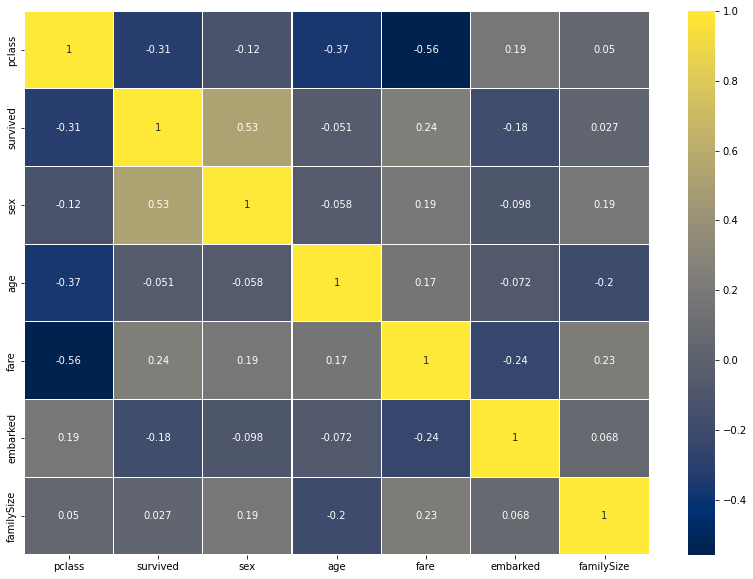

In [ ]:
corr = df.corr()
print(corr)
print(df.corr().abs().nlargest(3, 'survived').index)
colormap = plt.cm.Blues
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='cividis', annot=True, linewidths=0.2)

From this we can see the features that corrilated the most, and the ones that corrilated the least so lets check them out.

Pclass has a high corrilation value for survived so we will see how passenger class (Pclass) effected ones odds of survival.

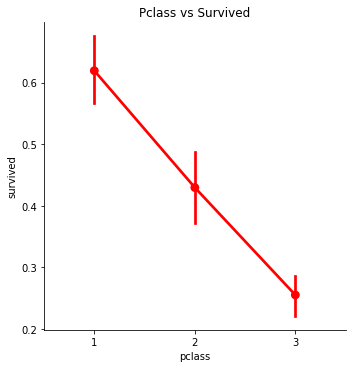

In [ ]:
sns.catplot(x="pclass", y="survived", data=df, kind="point", color = 'r')
plt.title("Pclass vs Survived")
plt.show()

The relation is basically linear, meaning it is very clear there is a solid relation between pclass and survivability. The higher the class the more likely the survival.

One thing that resinated with me was the fact that it is clear women were a priority, we can see that here.

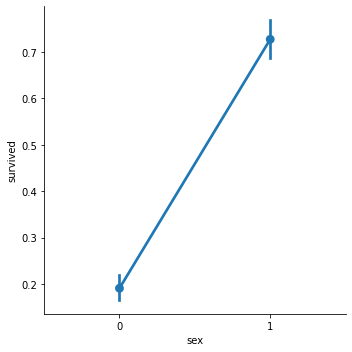

In [ ]:
sns.catplot(x="sex", y="survived", data=df, kind="point")

Remeber 0 is male and 1 is female. The despairity between the two is uncanny.
Which makes sence since the corrilation is high. Though I would expect a similar corrilation between age and survived considering at the time it was "save the women and children first".

I want to explore the relationship between age and survivability since its corrilation was lower than expected.

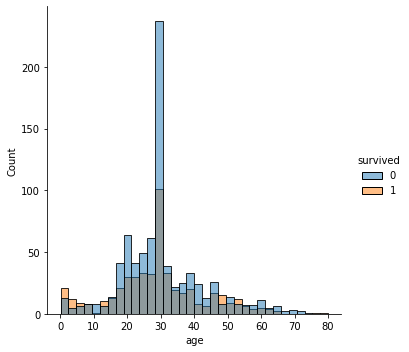

In [ ]:
sns.displot(x="age", data=df, hue = "survived")


You can see how the young children were actually a lot more likely to survive. Since the orange bar is bigger for younger children.

The next thing to look at would be the relation between sex and age

But first what is the distribution between male and female?

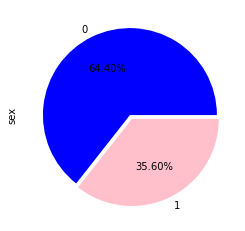

In [ ]:
explode = [0, 0.05]
df["sex"].value_counts().plot.pie(autopct="%1.2f%%", explode=explode, colors = ['b', 'pink'])

So its something to keep in mind, that their were almost double the males than females on the boat.

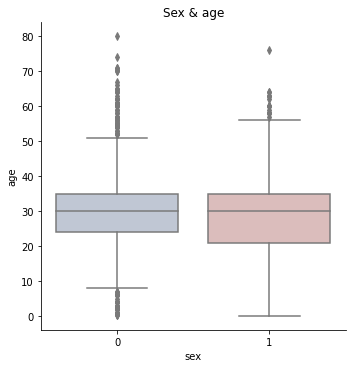

In [ ]:
sns.catplot(x="sex", y="age", data=df, palette = 'vlag', kind = 'box')
plt.title("Sex & age")
plt.show()

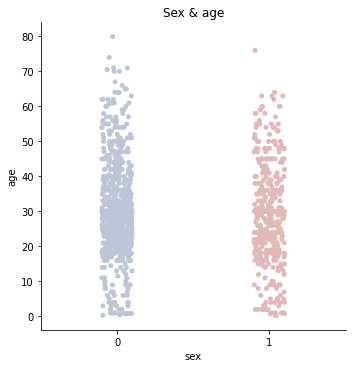

In [ ]:
sns.catplot(x="sex", y="age", data=df, palette = 'vlag')
plt.title("Sex & age")
plt.show()

From these two charts it clear that a majority of the population on the boat was adults starting at what looks like 18.
Though it looks like a majority of both men and women are around the ages from around 25 to 35, with women ranging a little lower at 20 to 35. Though they both have about the same mean at around 30.

So now lets add pclass and see how that effects things.

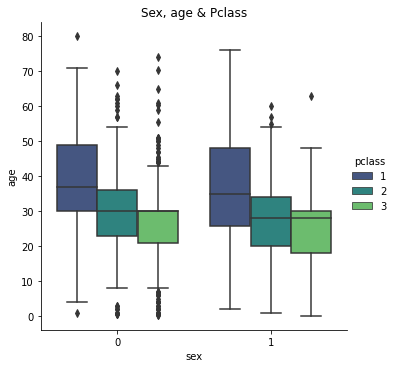

In [ ]:
sns.catplot(x="sex", y="age", data=df, kind="box", hue="pclass", palette = 'viridis')
plt.title("Sex, age & Pclass")
plt.show()

From this we can tell that the pclass distribution was fairly even over the sexs, but when it came to age, older people tended to be in a higher class.

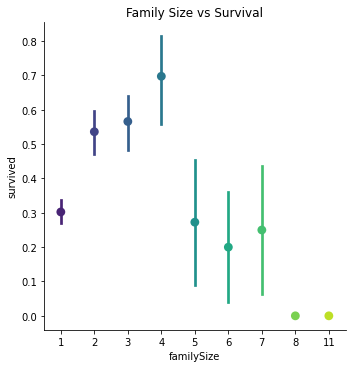

In [ ]:
sns.catplot(x="familySize", y="survived", data=df, kind="point", palette = 'viridis')
plt.title("Family Size vs Survival")
plt.show()

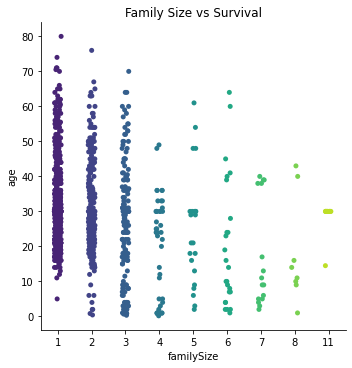

In [ ]:
sns.catplot(x="familySize", y="age", data=df, palette = 'viridis')
plt.title("Family Size vs Survival")
plt.show()

From these two charts its clear their is a relationship between your family size and whether or not you survived but also that your age corrilates on your family size. The second chart above shows that majority of kids came from families ranging in size from 3-7. This makes sense since, it would be unlikely for a child to come alone on the ship. But also that families of 2 would likely be a couple vs parent and child.

But first whats the distribution in family size since its hard to tell from above.

Text(0, 0.5, 'Count')

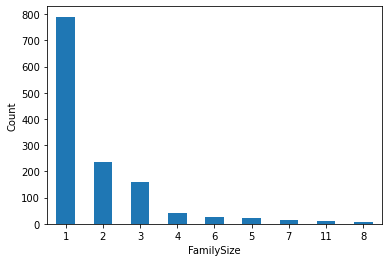

In [ ]:
ax = df["familySize"].value_counts().plot.bar(x='familySize', rot = 0)
ax.set_xlabel("FamilySize")
ax.set_ylabel("Count")

From this we can see that actually a majority of the passengers on the titanic came with out family, though I'm pretty sure that could still mean they came with a significant other.

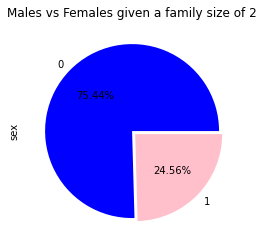

In [ ]:
df.loc[df['familySize'] == 1, 'sex'].value_counts().plot.pie(autopct="%1.2f%%", explode=explode, colors = ['b', 'pink'])
plt.title("Males vs Females given a family size of 2")
plt.show()

This tells us a lot though, as its clear a majority of the single passengers were male, which considering the difference in numbers of males and females across the whole boat, would mean most of that contrast between the two stems from single passengers. To confirm this I will show the data with single passengers removed.

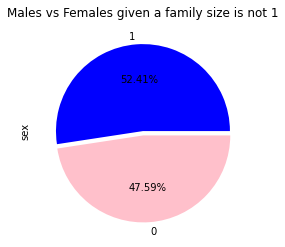

In [ ]:
explode = [0, 0.05]
df.loc[df['familySize'] != 1, 'sex'].value_counts().plot.pie(autopct="%1.2f%%", explode=explode, colors = ['b', 'pink'])
plt.title("Males vs Females given a family size is not 1")
plt.show()

This confirms my suspicion that the differnece in distribution between males and comes from the single passengers.

This makes me curious in the distribution between sexs when single riders have been removed. To start lets see how it looks again with single riders.

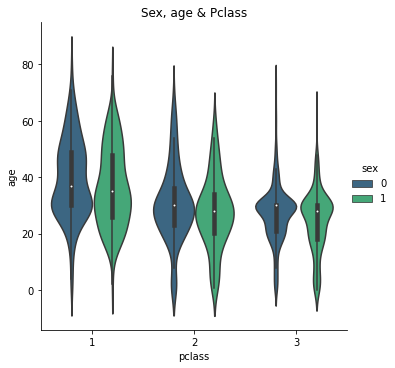

In [ ]:
sns.catplot(x="pclass", y="age", data=df, kind="violin", hue="sex", palette = 'viridis')
plt.title("Sex, age & Pclass")
plt.show()

Now we can drop all the values with family size 1 and see how it looks

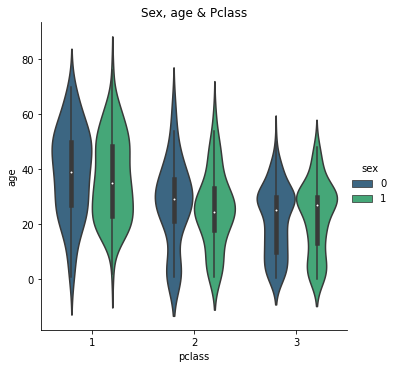

In [ ]:
dfDrop = df[df.familySize != 1]
sns.catplot(x="pclass", y="age", data=dfDrop, kind="violin", hue="sex", palette = 'viridis')
plt.title("Sex, age & Pclass")
plt.show()

You can see how the graph has changed, its only slight but their distribution is a lot more mirrored which means, families tend to have the same pclass and same distribution of males and females.

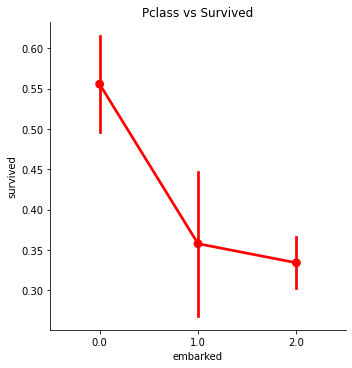

In [ ]:
sns.catplot(x="embarked", y="survived", data=df, kind="point", color = 'r')
plt.title("Pclass vs Survived")
plt.show()

This graph also shows us the importance of the station at which the passengers had to embark at to get on their life rafts. With 0 being Cherbourg, 1 being Queenstown, and 2 being Southampton.
Meaning if you left from Cherbourg you would have the highest chance of survival.

##Develope a Decision tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
dfDropS = df.drop(['survived'], axis=1)
X = dfDropS
y = df['survived']
kf =KFold(n_splits=5, shuffle=True, random_state=42)
cnt = 1

In [ ]:
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1

Fold:1, Train set: 1047, Test set:262
Fold:2, Train set: 1047, Test set:262
Fold:3, Train set: 1047, Test set:262
Fold:4, Train set: 1047, Test set:262
Fold:5, Train set: 1048, Test set:261


In [ ]:
score = cross_val_score(tree.DecisionTreeClassifier(random_state= 42), X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.77099237 0.76335878 0.76335878 0.79389313 0.75862069]
Average score: 0.77


These are pretty good but lets try and change the max depth parameter

We are testing for the best max depth parameter

In [ ]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth= val, random_state= 42), X, y, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(1): 0.780
Average score(2): 0.771
Average score(3): 0.807
Average score(4): 0.802
Average score(5): 0.778
Average score(6): 0.785
Average score(7): 0.782
Average score(8): 0.768
Average score(9): 0.779
Average score(10): 0.771


The best score here was 3 so we will set max depth to 3 and will use that to build our tree.

We train test split here to use the same split of data for both of our models.

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X ,
    y ,
    random_state= 42
    )
model = DecisionTreeClassifier(max_depth= 3, random_state= 42).fit(Xtrain, ytrain)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)


Text(91.68, 0.5, 'true label')

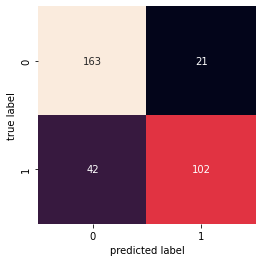

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label');
plt.ylabel('true label')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest, digits = 5))

              precision    recall  f1-score   support

           0    0.88587   0.79512   0.83805       205
           1    0.70833   0.82927   0.76404       123

    accuracy                        0.80793       328
   macro avg    0.79710   0.81220   0.80105       328
weighted avg    0.81929   0.80793   0.81030       328



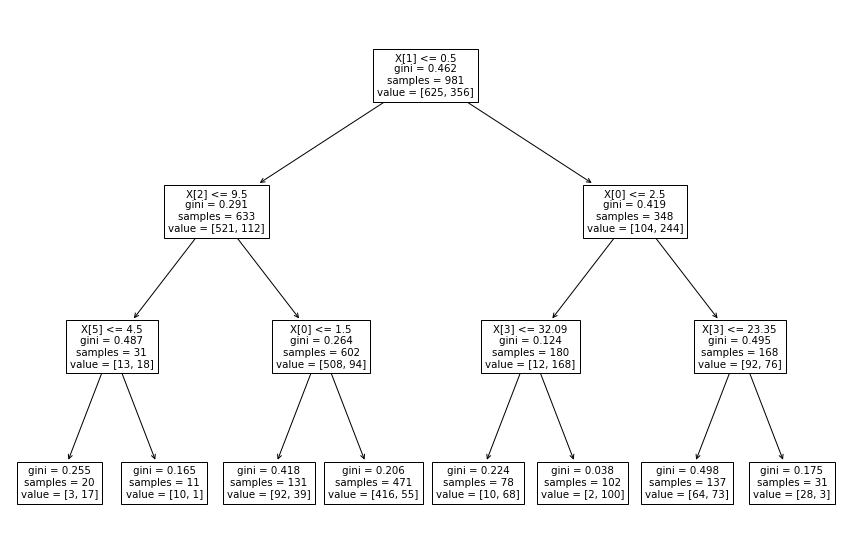

In [ ]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
model = DecisionTreeClassifier(max_depth= 3, random_state= 42).fit(Xtrain, ytrain)
plt.rcParams['figure.figsize'] = [15,10]

plot_tree( model )
plt.show()

##Random Tree Classifier

In [ ]:
score = cross_val_score(ensemble.RandomForestClassifier(random_state= 42), X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.5f}".format(score.mean())}')

Scores for each fold are: [0.79770992 0.79007634 0.79389313 0.8129771  0.78544061]
Average score: 0.79602


We need to check for the best n_estimator parameter

In [ ]:
n_estimators = [50, 100, 150, 200, 250, 300, 350]

for val in n_estimators:
    score = cross_val_score(ensemble.RandomForestClassifier(n_estimators= val, random_state= 42), X, y, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(50): 0.790
Average score(100): 0.796
Average score(150): 0.788
Average score(200): 0.791
Average score(250): 0.792
Average score(300): 0.788
Average score(350): 0.788


We can see here that the best n_estimators is 100 and it has an average score of 0.796

We can build a model and see how it works using our previously split data.

Text(260.70000000000005, 0.5, 'true label')

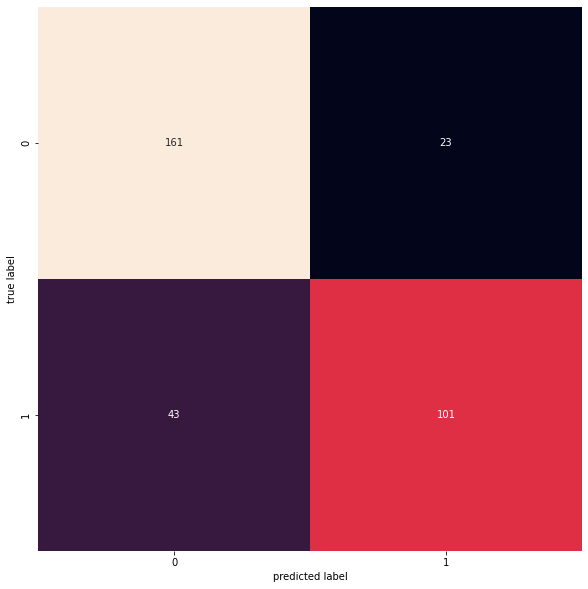

In [ ]:
from sklearn.metrics import confusion_matrix
model = RandomForestClassifier(n_estimators= 100, random_state= 42)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label');
plt.ylabel('true label')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest, digits = 5))

              precision    recall  f1-score   support

           0    0.87500   0.78922   0.82990       204
           1    0.70139   0.81452   0.75373       124

    accuracy                        0.79878       328
   macro avg    0.78819   0.80187   0.79181       328
weighted avg    0.80937   0.79878   0.80110       328



# Conclusions

The decision tree did slightly better than the RandomForest Classifier model. The decision tree predicted 3 more passengers correctly from the split we used. But we can also see that using the k-fold the average for score for the decision tree is slightly better than that of the RandomForest Classifier. From what I can find about Decision trees and RandomForest is that Random forest is supposed to be more accurate most of the time since it uses multiple single trees based on a random sample of the training data.